# Vision guide
In this example, the robot remains stationary while capturing an image. You can use this image to determine the desired pixel location. Subsequently, the robot will navigate to the corresponding point identified in the image.

This code snippet sets up a vision-guided task involving a robot and a camera. It imports necessary modules, establishes connections with the camera and robot, and defines parameters for calibration and movement. The robot is positioned at a capturing location, and an image is obtained from the camera. The image is displayed using Matplotlib. After selecting a pixel in the image, its corresponding 3D coordinates are computed using camera calibration data. The robot then moves to the calculated target position in its workspace. Finally, the camera and robot connections are closed.

In [16]:
%matplotlib widget
import matplotlib.pyplot as plt
from camera import Camera
from dorna2 import Dorna, Kinematic
import cv2
import numpy as np

In [17]:
"""
System parameters
Make sure to put the right toolhead length
Otherwise the robot collides with the object
"""
# fine tuned camera parameter
T_cam_2_j4 = np.matrix([[-9.99959277e-01,  1.84204328e-03,  8.81549264e-03,  6.6706658],
                         [-1.88694138e-03, -9.99985335e-01,  5.10967554e-03,  47.3318662],
                         [ 8.82523344e-03, -5.09283314e-03,  9.99948088e-01,  3.35374306e+01],
                         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

toolhead_length =  # in mm
robot_ip = # robot ip address 
model = "dorna_ta"

In [21]:
"""
Initialize camera, robot and the inverse kinematic engine
"""

# camera
camera = Camera()
print("Camera connected: ", camera.connect())

# Robot
robot = Dorna()
print("Robot connected: ", robot.connect(robot_ip))

# kinematics
kinematic = Kinematic(model)  

Camera connected:  True
Robot connected:  True


In [26]:
"""
Send the robot to a position to take a sample photo
"""
# move the robot to the capturing position
robot.set_motor(1)
robot.jmove(rel=0, vel=50, accel=800, jerk=1000, j0=0,j1=27,j2=-100,j3=0,j4=-17, j5=0)
robot.sleep(1)

2.0

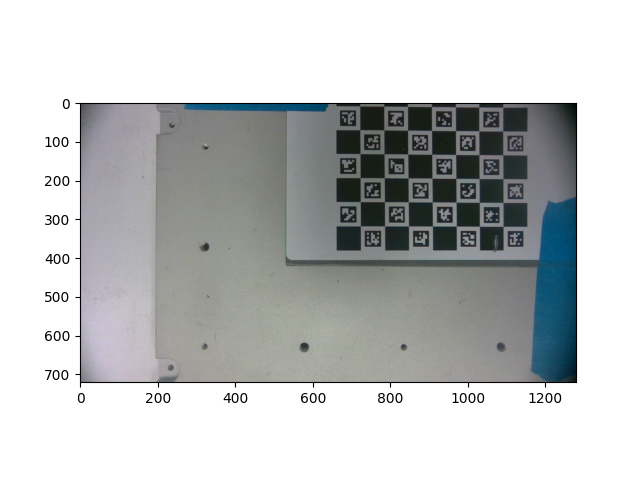

In [28]:
"""
Display the image, and use the viewer to find a pixel of interest
"""
# camera data
depth_frame, _, _, _, _, color_img, depth_int, _, _= camera.get_all()

# Display the image
fig, ax = plt.subplots(frameon=False)
ax.imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))
plt.show()

In [29]:
"""
Put the pixel coordinates here as px and py,
The camera finds the pixel location with respect to the camera and converts it to the robot coordinate system 
"""
# destination pixel to the robot frame
px, py = 329, 498

# T_target_2_cam
xyz_target_2_cam, _ = camera.xyz((px, py), depth_frame, depth_int)
T_target_2_cam = np.eye(4)
T_target_2_cam[:3, 3] = np.ravel(xyz_target_2_cam)

# current joint and pose
joint = robot.get_all_joint()
T_j4_2_base = kinematic.Ti_r_world(i=5, joint=joint[0:6])

# target_2_base
T_target_2_base = np.matmul(T_j4_2_base, np.matmul(T_cam_2_j4, T_target_2_cam) )
xyz_target_2_base =T_target_2_base[:3, 3].flatten().tolist()[0] 
print('xyz_target_2_cam: ', xyz_target_2_cam)
print("xyz_target_2_base: ", xyz_target_2_base)

xyz_target_2_cam:  [-56.49036914  26.46249533 123.79999459]
xyz_target_2_base:  [382.58790890908324, 25.591069235200113, 1.3074421790428516]


In [30]:
"""
Command the robot to appraoch the desired pixel from the top.
Make sure to set the right toolhead parameter
"""
# robot motion
robot.set_motor(1)
robot.sleep(1)
robot.jmove(rel=0, vel=50, accel=800, jerk=1000, x=xyz_target_2_base[0], y=xyz_target_2_base[1], z=xyz_target_2_base[2]+toolhead_length)

2.0

In [31]:
"""
Always close the camera and robot, once your application is over
"""
# terminate the session
camera.close()
robot.close()

True